# _UNC or Duke: Deep Learning with Logos_

**Introduction**

While listening to Lex Fridman and Jeremy Howard recently on a [podcast](https://www.youtube.com/watch?v=J6XcP4JOHmk) (highly recommend check it out!), I heard Jeremy mention that one of the best ways to become an expert DL practitioner was, essentially, to build a ton of models (with data your interested in of course)! 

So that is the aim of this notebook: to generate a deep learning model to predict something I'm interested in. More specifically, we'll be using a data set of images that contain UNC's or Duke's logo, and training it to recognize each one! 

First thing we need to do though is ensure our `path` variable is set. What is this variable going to do? `path` will help us make sure we're in the main directory. It can get confusing once you get into a project to keep track of everything so knowing we always have a link back to the main directory helps big time. 

In [ ]:
# make sure PyTorch and fastai are up-to-date
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U

In [ ]:
from fastai.vision import *

## _Set `path` and `dest` variables for environment_

In [3]:
# mount your google drive so you can save to it
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# import os and Path from pathlib library
import os 
from pathlib import Path

# get current working directory
print('My current working directory is {}'.format(os.getcwd()))

My current working directory is /content


In [ ]:
# change working directory to the one below
os.chdir('/content/gdrive/My Drive/projects/unc_duke')

In [6]:
# check current working directory now
print('My current working directory is {}'.format(os.getcwd()))

My current working directory is /content/gdrive/My Drive/projects/unc_duke


In [7]:
#create path variable to primary directory
path = Path(os.getcwd())
print(path)

/content/gdrive/My Drive/projects/unc_duke


## _Create directories for UNC/Duke images and Upload URLs file_

In [ ]:
# create folder and file_name for UNC upload
folder = 'unc'
file_name = 'unc_links.csv'

In [ ]:
# create destination variable
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

## _Download Images For UNC_

In [ ]:
classes = ['unc', 'duke']

In [ ]:
download_images(path/file_name, dest, max_pics=200)

## _Download Images For Duke_

In [ ]:
# create folder and file_name for Duke upload
folder = 'duke'
file_name = 'duke_links.csv'

In [ ]:
# create destination variable
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file_name, dest, max_pics=200)

In [9]:
# check to make sure everything worked
path.ls()

[PosixPath('/content/gdrive/My Drive/projects/unc_duke/unc_links.csv'),
 PosixPath('/content/gdrive/My Drive/projects/unc_duke/duke_links.csv'),
 PosixPath('/content/gdrive/My Drive/projects/unc_duke/models'),
 PosixPath('/content/gdrive/My Drive/projects/unc_duke/test'),
 PosixPath('/content/gdrive/My Drive/projects/unc_duke/train')]

In [ ]:
# remove any images that can't be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## _View Data_

In [ ]:
np.random.seed(1)

tfms = get_transforms(do_flip=False, max_zoom=1, xtra_tfms=[crop_pad()])

data = ImageDataBunch.from_folder(path/'train', valid_pct=0.2,
        ds_tfms=tfms, size=320, num_workers=4, bs=32).normalize(imagenet_stats)

In [19]:
data

ImageDataBunch;

Train: LabelList (164 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
unc,unc,unc,unc,unc
Path: /content/gdrive/My Drive/projects/unc_duke/train;

Valid: LabelList (40 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
duke,duke,unc,duke,duke
Path: /content/gdrive/My Drive/projects/unc_duke/train;

Test: None

In [ ]:
data.add_test(ImageList.from_folder(path/'test'))

In [21]:
data

ImageDataBunch;

Train: LabelList (164 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
unc,unc,unc,unc,unc
Path: /content/gdrive/My Drive/projects/unc_duke/train;

Valid: LabelList (40 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
duke,duke,unc,duke,duke
Path: /content/gdrive/My Drive/projects/unc_duke/train;

Test: LabelList (10 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/projects/unc_duke/train

In [22]:
data.classes

['duke', 'unc']

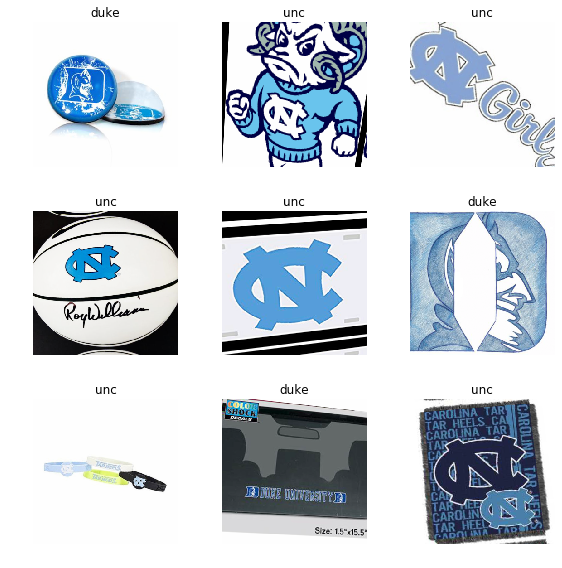

In [23]:
data.show_batch(rows=3, figsize=(8,8))

In [24]:
# print out classes, number of classes and lengths of training/validation sets
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['duke', 'unc'], 2, 164, 40)

## _Create Initial Model: `resnet34`_

In [ ]:
from fastai.callbacks import SaveModelCallback

# create learner
learn = cnn_learner(data, models.resnet34,
                    metrics=accuracy,
                    pretrained=True,
                    bn_final=True,
                    path=path)

In [26]:
# train model for 5 epochs, saving the model weights every time accuracy improves
learn.fit_one_cycle(5, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                     monitor='accuracy', 
                                                     name='unc-duke-trial1'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.810690,0.485516,0.800000,00:08
1,0.555058,0.241592,0.925000,00:06
2,0.444780,0.198738,0.900000,00:05
3,0.384025,0.181156,0.900000,00:06
4,0.349751,0.173979,0.925000,00:06


Better model found at epoch 0 with accuracy value: 0.800000011920929.
Better model found at epoch 1 with accuracy value: 0.925000011920929.


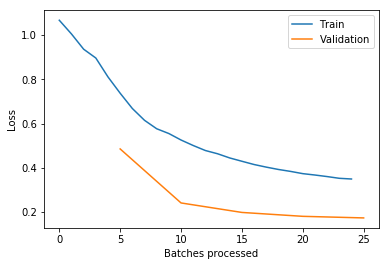

In [32]:
# plot losses from training & validation
learn.recorder.plot_losses()

In [ ]:
# save model weights after very last epoch
learn.save('unc-duke-rd1-end');

In [ ]:
# reload weights (this also helps keep our memory allocation from freaking out)
learn.load('unc-duke-trial1');

In [ ]:
# perform disciminative layer training, to allow lower layers weights to be updated to hopefully boost performance
learn.unfreeze()

In [36]:
# using 1cycle policy, find best learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 7.59E-04


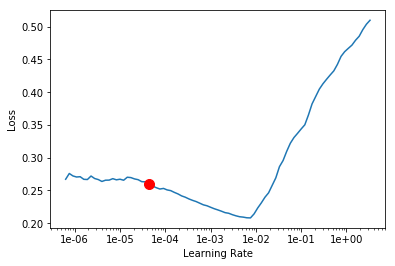

In [37]:
# plot 1cycle policy from above
learn.recorder.plot(suggestion=True)

In [38]:
# train for 5 more epochs, with smaller learning rate for lower layers, higher learning rate for higher layers
# and saving best performing model based on accuracy
learn.fit_one_cycle(5, max_lr=slice(7e-4, 1e-3), callbacks=[(SaveModelCallback(learn, 
                                                                               every='improvement', 
                                                                               monitor='accuracy', 
                                                                               name='unc-duke-trial2'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.259112,0.313412,0.925000,00:07
1,0.236715,0.344866,0.875000,00:06
2,0.224685,0.111119,0.975000,00:06
3,0.207349,0.046151,0.950000,00:07
4,0.194271,0.067002,0.950000,00:06


Better model found at epoch 0 with accuracy value: 0.925000011920929.
Better model found at epoch 2 with accuracy value: 0.9750000238418579.


In [ ]:
# save model weights after last epoch
learn.save('unc-duke-end-trial2')

## _Interpretation_

In [ ]:
# reload weights
learn.load('unc-duke-end-trial2');

In [ ]:
# create object that allows us to interpret performance of model
interp = ClassificationInterpretation.from_learner(learn)

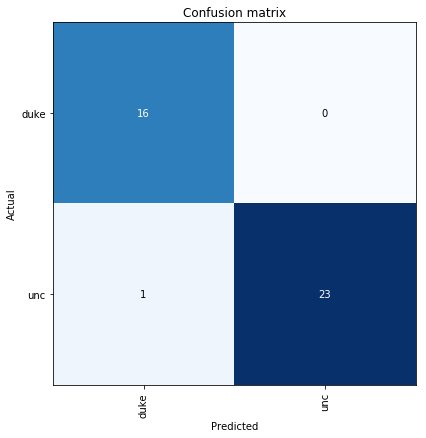

In [42]:
# plot confusion matrix which shows all true labels, and any false positive/negatives
interp.plot_confusion_matrix(figsize=(6,6))

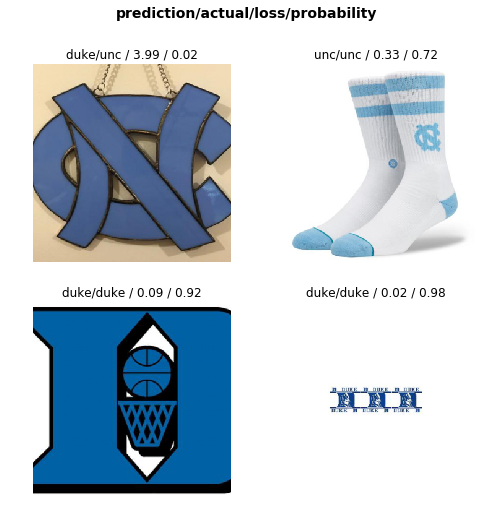

In [44]:
# images that had highest loss (i.e. most wrong)
interp.plot_top_losses(4, figsize=(8,8), heatmap=False)

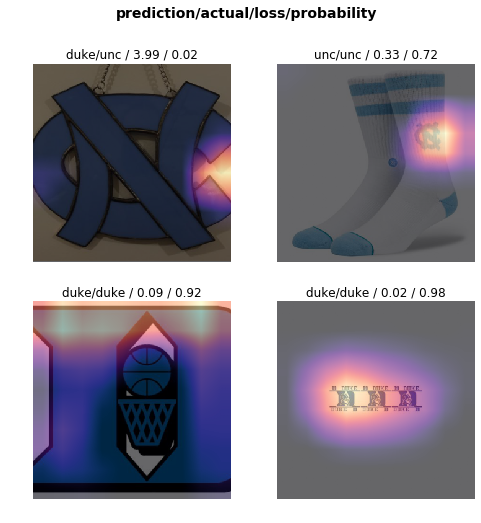

In [45]:
# same as above but also shows pixels that most contributed to model's decisions
interp.plot_top_losses(4, figsize=(8,8), heatmap=True)

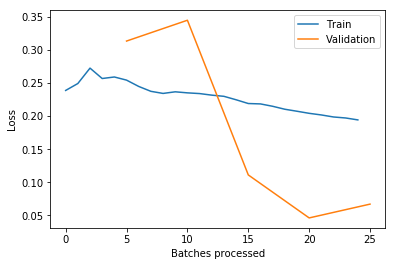

In [46]:
# plot losses from training period
learn.recorder.plot_losses()

## _Go Big...ger?_

Our `resnet34` has done pretty good with an accuracy of ~95%! Let's see what a `resnet50` might be able to do though.

In [ ]:
# create learner
learn_50 = cnn_learner(data, models.resnet50, # use a pretrained resnet50 architecture
                    metrics=accuracy,
                    pretrained=True,
                    bn_final=True, # batch normalization, allows each layer to learn a little more independently from the others
                    path=path)

In [48]:
# train resnet50 for 5 epochs, saving most accurate model
learn_50.fit_one_cycle(5, callbacks=[(SaveModelCallback(learn_50, every='improvement', 
                                                     monitor='accuracy', 
                                                     name='unc-duke-trial1-resnet50'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.748516,0.741307,0.800000,00:23
1,0.497197,0.315155,0.925000,00:08
2,0.397847,0.182562,0.925000,00:08
3,0.345343,0.160791,0.925000,00:08
4,0.312566,0.158861,0.925000,00:08


Better model found at epoch 0 with accuracy value: 0.800000011920929.
Better model found at epoch 1 with accuracy value: 0.925000011920929.


In [ ]:
# save post-training weights
learn_50.save('unc-duke-end1-resnet50');

In [ ]:
# load post-training weights
learn_50.load('unc-duke-end1-resnet50');

In [ ]:
# unfreeze model weights to allow for disciminative layer training
learn_50.unfreeze()

In [53]:
# using 1cycle policy, see what best learning rate is
learn_50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 2.51E-04


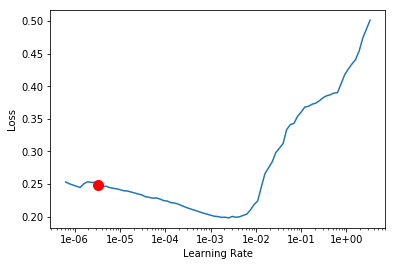

In [54]:
# plot 1cycle results
learn_50.recorder.plot(suggestion=True)

In [55]:
# with unfrozen architecture, train for 5 epochs, with a smaller learning rate for lower layers, higher learning rate for higher ones
learn_50.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4), callbacks=[(SaveModelCallback(learn_50, every='improvement', 
                                                                                  monitor='accuracy', 
                                                                                  name='unc-duke-trial2-resnet50'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.241894,0.185680,0.925000,00:10
1,0.231957,0.124357,0.950000,00:10
2,0.216164,0.121021,0.950000,00:11
3,0.203820,0.126861,0.950000,00:10
4,0.195850,0.134475,0.950000,00:10


Better model found at epoch 0 with accuracy value: 0.925000011920929.
Better model found at epoch 1 with accuracy value: 0.949999988079071.


In [ ]:
# save post-training weights
learn_50.save('unc-duke-end2-resnet50')

In [ ]:
# load post-training weights
learn_50.load('unc-duke-end2-resnet50');

## _Interpretation: `resnet50`_

In [ ]:
# create object so we can assess performance of model
interp_50 = ClassificationInterpretation.from_learner(learn_50)

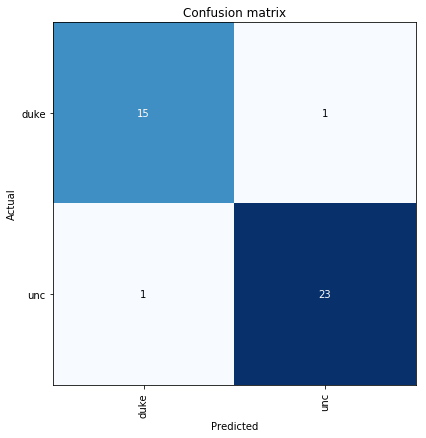

In [60]:
# confusion matrix indicating all true labels and the false positives/negatives
interp_50.plot_confusion_matrix(figsize=(6,6))

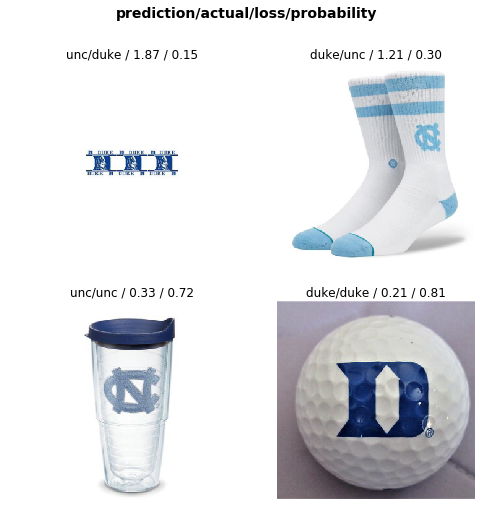

In [62]:
# display images that had the top losses (i.e. most wrong)
interp_50.plot_top_losses(4, figsize=(8,8), heatmap=False)

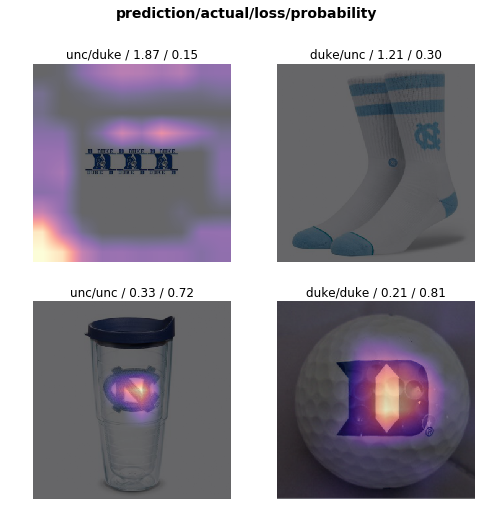

In [63]:
# same as above, but shows pixels that contributed most towards the model's decision
interp_50.plot_top_losses(4, figsize=(8,8), heatmap=True)

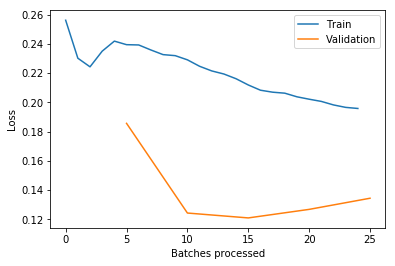

In [64]:
learn_50.recorder.plot_losses()

## _Predict on Test Set_

In [ ]:
# get predictions from best performing model
preds, y = learn_50.get_preds(DatasetType.Test)

In [102]:
# names of the pictures in test set
for n in range(10):
    print(str(data.test_ds.x.items[n])[49:60])

0000014.jpg
0000023.jpg
0000025.png
0000060.jpg
0000098.JPG
0000008.jpg
0000040.jpg
0000050.jpg
0000063.jpg
0000093.jpg


In [103]:
# extract picture names and append to list
picture_list = []

for n in range(10):
    pic_name = str(data.test_ds.x.items[n])[49:60]
    picture_list.append(pic_name)

picture_list

['0000014.jpg',
 '0000023.jpg',
 '0000025.png',
 '0000060.jpg',
 '0000098.JPG',
 '0000008.jpg',
 '0000040.jpg',
 '0000050.jpg',
 '0000063.jpg',
 '0000093.jpg']

In [104]:
# return probabilities for each item in test set
preds

tensor([[0.0556, 0.9444],
        [0.0076, 0.9924],
        [0.0537, 0.9463],
        [0.1602, 0.8398],
        [0.0270, 0.9730],
        [0.9979, 0.0021],
        [0.9061, 0.0939],
        [0.8905, 0.1095],
        [0.9047, 0.0953],
        [0.9077, 0.0923]])

In [109]:
numpy_preds = preds.numpy(); numpy_preds

array([[0.055649, 0.944351],
       [0.0076  , 0.9924  ],
       [0.053655, 0.946345],
       [0.160154, 0.839846],
       [0.027033, 0.972967],
       [0.997909, 0.002091],
       [0.906121, 0.093879],
       [0.890511, 0.109489],
       [0.904659, 0.095341],
       [0.907741, 0.092259]], dtype=float32)

In [112]:
numpy_preds[1][0]

0.007600217

In [116]:
preds1 = []
# extract first column of prediction values
for n in range(10):
    x = numpy_preds[n][0]
    preds1.append(x)

preds1

[0.05564865,
 0.007600217,
 0.053655036,
 0.16015372,
 0.027033059,
 0.9979091,
 0.9061212,
 0.89051133,
 0.90465873,
 0.9077409]

In [117]:
preds2 = []

# extract second column of prediction values
for n in range(10):
    x = numpy_preds[n][1]
    preds2.append(x)

preds2

[0.9443514,
 0.99239975,
 0.946345,
 0.83984625,
 0.97296697,
 0.0020907938,
 0.09387884,
 0.10948862,
 0.09534128,
 0.09225914]

In [110]:
# convert probabilities into labels 
labels = np.argmax(preds, 1)
labels_with_names = [data.classes[i].replace('_', ' ') for i in labels]; labels_with_names

['unc', 'unc', 'unc', 'unc', 'unc', 'duke', 'duke', 'duke', 'duke', 'duke']

In [123]:
# create a dictionary that will store all this information
test_dictionary = {'picture_file': picture_list, 'preds1': preds1, 'preds2': preds2, 'predictions': labels_with_names}; test_dictionary

{'picture_file': ['0000014.jpg',
  '0000023.jpg',
  '0000025.png',
  '0000060.jpg',
  '0000098.JPG',
  '0000008.jpg',
  '0000040.jpg',
  '0000050.jpg',
  '0000063.jpg',
  '0000093.jpg'],
 'predictions': ['unc',
  'unc',
  'unc',
  'unc',
  'unc',
  'duke',
  'duke',
  'duke',
  'duke',
  'duke'],
 'preds1': [0.05564865,
  0.007600217,
  0.053655036,
  0.16015372,
  0.027033059,
  0.9979091,
  0.9061212,
  0.89051133,
  0.90465873,
  0.9077409],
 'preds2': [0.9443514,
  0.99239975,
  0.946345,
  0.83984625,
  0.97296697,
  0.0020907938,
  0.09387884,
  0.10948862,
  0.09534128,
  0.09225914]}

In [125]:
test_results_df = pd.DataFrame(test_dictionary); test_results_df

,picture_file,preds1,preds2,predictions
0,0000014.jpg,0.055649,0.944351,unc
1,0000023.jpg,0.007600,0.992400,unc
2,0000025.png,0.053655,0.946345,unc
3,0000060.jpg,0.160154,0.839846,unc
4,0000098.JPG,0.027033,0.972967,unc
5,0000008.jpg,0.997909,0.002091,duke
6,0000040.jpg,0.906121,0.093879,duke
7,0000050.jpg,0.890511,0.109489,duke
8,0000063.jpg,0.904659,0.095341,duke
9,0000093.jpg,0.907741,0.092259,duke


In [ ]:
# export dataframe above to csv
test_results_df.to_csv('unc-duke-resnet50-test-results.csv', header=list(test_results_df.columns))